# Tow approaches to passing ratio of mDOM to pDOM

Passing ratio is defined by $\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$ with $\eta_x$ to veto efficiency of Optical Module $x$.

In [22]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings('ignore')

Function checking if number is even.

In [23]:
def is_even(num):
    return num % 2 == 0

Function giving logarithm of binomial coefficient (a take b).

In [24]:
def binomln(a, b):
    return sp.special.gammaln(a+1) - sp.special.gammaln(b+1) - sp.special.gammaln(a-b+1)

Function giving for a set of veto efficiencies ($\texttt{etas}$) and set of #veto hits ($\texttt{v}$) and # all hits ($\texttt{a}$) the beta distribution of $\eta$.

In [227]:
def prob_dist_beta(eta, v, a):
    if (eta == 0.0 or eta == 1.0):
        return 0.0
    else:
        return np.exp((v-1)*np.log(eta) + (a-v-1)*np.log(1-eta) - (sp.special.betaln(v, a-v)))

## <font color='orange'>Analytical approach</font>
The two cases ($0<w\leq1$ and $w\geq1$) of hypergeometric functions that will be used below ($1 - \beta_i$ are non-positive). (see page 40, Yudell L. Luke, 1969)

${}_2F_1(\alpha_1 + \alpha_2, 1-\beta_1; \alpha_1 + \alpha_2 + \beta_2; w) = \sum_{n=0}^{\beta_1-1}(-1)^n \begin{pmatrix} \beta_1-1 \\ n\end{pmatrix} \frac{(\alpha_1+\alpha_2+n-1)!\cdot(\alpha_1+\alpha_2+\beta_2-1)!}{(\alpha_1+\alpha_2+\beta_2+n-1)!\cdot(\alpha_1+\alpha_2-1)!} w^n$ for $w<1$

${}_2F_1(\alpha_1 + \alpha_2, 1-\beta_2; \alpha_1 + \alpha_2 + \beta_1; \frac{1}{w}) = \sum_{n=0}^{\beta_2-1}(-1)^n \begin{pmatrix} \beta_2-1 \\ n\end{pmatrix} \frac{(\alpha_1+\alpha_2+n-1)!\cdot(\alpha_1+\alpha_2+\beta_1-1)!}{(\alpha_1+\alpha_2+\beta_1+n-1)!\cdot(\alpha_1+\alpha_2-1)!} \left(\frac{1}{w}\right)^n$ for $w\geq1$

The results for even and odd $n$ are stored separated and substracted in the end each. For purpose of further implementation define the $\log({_2F_1})$.

In [228]:
def log_hyper_2_F_1_below_1(a1, a2, b1, b2, w):
    ln_results_even = np.array([])
    ln_results_odd = np.array([])
    for n in range(b1):
        ln_resu = binomln(b1-1, n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a1+a2+b2) - sp.special.gammaln(a1+a2+b2+n) - sp.special.gammaln(a1+a2) + n * np.log(w)
        if is_even(n):
            ln_results_even = np.append(ln_results_even, ln_resu)
        else:
            ln_results_odd = np.append(ln_results_odd, ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
    ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b=[1,-1])
    return ln_result

def log_hyper_2_F_1_above_1(a1, a2, b1, b2, w):
    ln_results_even = np.array([])
    ln_results_odd = np.array([])
    for n in range(b2):
        ln_resu = binomln(b2-1, n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a1+a2+b1) - sp.special.gammaln(a1+a2+b1+n) - sp.special.gammaln(a1+a2) - n * np.log(w)
        if is_even(n):
            ln_results_even = np.append(ln_results_even, ln_resu)
        else:
            ln_results_odd = np.append(ln_results_odd, ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
    ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b=[1,-1])
    return ln_result

Test for the 'w=1' case. There actually both values of the two cases should give the same results since the distribution is assumed to be continuous.

In [229]:
''' Test for the w=1 case'''
a1, a2, b1, b2, wi = 52, 56, 70, 70, 1
lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
aa = np.exp(sp.special.betaln(a1+a2, b2) + (a1-1) * np.log(wi) + log_hyper_2_F_1_below_1(a1, a2, b1, b2, wi) - lnA)
bb = np.exp(sp.special.betaln(a1+a2, b1) - (a2+1) * np.log(wi) + log_hyper_2_F_1_above_1(a1, a2, b1, b2, wi) - lnA)
if aa != bb:
    print('Argh!')
print(aa - bb)

Argh!
nan


/usr/local/lib/python3.5/dist-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


Here, finally, apply the hypergeometric functions in the quotien distribution (see T. Pham-Gia, 2000).

In [230]:
def pdf_ratio(a1, a2, b1, b2, w):
    lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
    result = np.zeros(len(w))
    for i in range(len(w)):
        wi = w[i]
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(0)
        elif wi == 0:
            result[i] = 0
        elif wi < 1:
            result[i] = np.exp(sp.special.betaln(a1+a2, b2) + (a1-1) * np.log(wi) + log_hyper_2_F_1_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            result[i] = np.exp(sp.special.betaln(a1+a2, b1) - (1+a2) * np.log(wi) + log_hyper_2_F_1_above_1(a1, a2, b1, b2, wi) - lnA)
    return result

Change the argument, such that $\texttt{veto hits}$ and $\texttt{all hits}$ give the distribution of the passing fraction $\frac{1-\frac{v_1}{a_1}}{1-\frac{v_2}{a_2}}$. In practice $a_1 = a_2$.

In [231]:
def custom_pdf_ratio(v1, v2, a1, a2, w):
    '''vi and ai here are the number of vetoed / all events for module i'''
    return pdf_ratio(a1-v1, a2-v2, v1, v2, w)

On a certain interval (e.g. [0, 3]) plot the quotient distribution with indicated expected mean (from raw calculation $\frac{1-\frac{v_1}{a_1}}{1-\frac{v_2}{a_2}}$) and directly obtained mean (via integrating the distribution).

In [232]:
n_veto_hits_mdom = 2
n_veto_hits_pdom = 1
n_hits = 4

Expectation value: 0.722073727924
Naively expected value: 0.6666666666666666


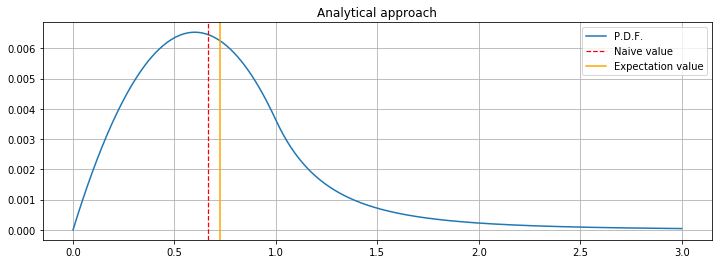

In [233]:
w = np.linspace(0, 3, 501)
p = custom_pdf_ratio(n_veto_hits_mdom, n_veto_hits_pdom, n_hits, n_hits, w)
norm = np.nansum(p)
p = p/norm

expect = np.dot(w, p)
print('Expectation value: ' + str(expect))

naive_expect = (n_hits - n_veto_hits_mdom)/(n_hits - n_veto_hits_pdom)
print('Naively expected value: ' + str(naive_expect))

plt.plot(w, p, label = 'P.D.F.')
plt.rcParams['figure.figsize'] = (12, 4)
plt.grid(True)
plt.title('Analytical approach')
plt.axvline(x = naive_expect, linewidth = 1.25, color = 'red', linestyle = '--', label = 'Naive value')
plt.axvline(x = expect, linewidth = 1.5, color = 'orange', label = 'Expectation value')
plt.legend(loc = 'best')
plt.show()

## <font color='orange'>Numerical approach</font>

In [234]:
res = 1000

n_veto_hits_mdom = float(n_veto_hits_mdom)
n_veto_hits_pdom = float(n_veto_hits_pdom)
n_hits = float(n_hits)

veto_efficiency_mdom = n_veto_hits_mdom / n_hits
veto_efficiency_pdom = n_veto_hits_pdom / n_hits

e = np.linspace(0, 1, res + 1)

p_mdom = np.array([prob_dist_beta(ei, n_veto_hits_mdom, n_hits) for ei in e])
p_pdom = np.array([prob_dist_beta(ei, n_veto_hits_pdom, n_hits) for ei in e])

p_inv_mdom = np.array([prob_dist_beta(1.0-ei, n_veto_hits_mdom, n_hits) for ei in e])
p_inv_pdom = np.array([prob_dist_beta(1.0-ei, n_veto_hits_pdom, n_hits) for ei in e])

one_over_p_inv_pdom = 1.0/p_inv_pdom
#one_over_p_inv_pdom[0] = 0
#one_over_p_inv_pdom[-1] = 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


Numerical procedure calculating the 90% errors on veto efficiencies of pDOM and mDOM. Then calculating the maximal possible (and over-estimated) error ($[\frac{1-\eta_{mDOM}-\Delta_{mDOM\downarrow}}{1-\eta_{pDOM}+\Delta_{pDOM\uparrow}}, \frac{1-\eta_{mDOM}+\Delta_{mDOM\uparrow}}{1-\eta_{pDOM}-\Delta_{pDOM\downarrow}}]$).

In [235]:
error_size = 0.9
step_size = 0.00001

def num_error(eta, vetohits, nhits = n_hits, errorsize = error_size, stepsize = step_size):
    if eta < 0.5:
        low = 0.0
        top = 1.0 - stepsize
    elif eta >= 0.5:
        low = 0.0 + stepsize
        top = 1.0

    interval = 1.0

    while interval >= errorsize:
        low_p = prob_dist_beta(low, vetohits, nhits)
        top_p = prob_dist_beta(top, vetohits, nhits)
        low_cp = sp.special.betainc(vetohits+1, nhits-vetohits+1, low)
        top_cp = sp.special.betainc(vetohits+1, nhits-vetohits+1, top)
        interval = top_cp - low_cp
        if low_p > top_p:
            top = top - stepsize
        else:
            low = low + stepsize
    return low, top

low_pdom, top_pdom = num_error(veto_efficiency_pdom, n_veto_hits_pdom)
low_mdom, top_mdom = num_error(veto_efficiency_mdom, n_veto_hits_mdom)
        
delta_low_pdom = veto_efficiency_pdom - low_pdom
delta_top_pdom = top_pdom - veto_efficiency_pdom
delta_low_mdom = veto_efficiency_mdom - low_mdom
delta_top_mdom = top_mdom - veto_efficiency_mdom

ratio = (1-veto_efficiency_mdom)/(1-veto_efficiency_pdom)
over_error_top = (1-low_mdom)/(1-top_pdom)
over_error_low = (1-top_mdom)/(1-low_pdom)

Check the mean of the simple beta distributions of veto efficiencies.

In [236]:
expect_mdom = 0.0
for i in range(len(p_mdom)):
    expect_mdom += p_mdom[i]*e[i]*(1/res)
print(expect_mdom)

expect_pdom = 0.0
for i in range(len(p_pdom)):
    expect_pdom += p_pdom[i]*e[i]*(1/res)
print(expect_pdom)

expect_one_over_p_inv_pdom = 0.0
for i in range(len(one_over_p_inv_pdom)):
    expect_one_over_p_inv_pdom += one_over_p_inv_pdom[i]*e[i]*(1/res)
print(expect_one_over_p_inv_pdom)

0.4999995
0.24999975
nan


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Plot the beta distributions of $\eta_{pDOM}$ and $\eta_{mDOM}$ with corresponding error range.

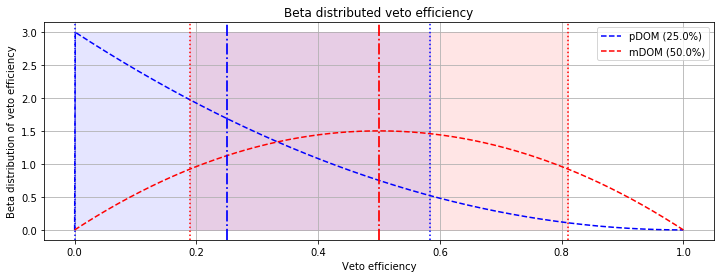

In [237]:
plt.title('Beta distributed veto efficiency')
plt.rcParams['figure.figsize'] = (12, 4)
plt.plot(e, p_pdom, '--', label = 'pDOM ({}%)'.format(100*veto_efficiency_pdom), color = 'blue')
plt.axvline(x = low_pdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'blue')
plt.axvline(x = top_pdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'blue')
plt.plot(e, p_mdom, '--', label = 'mDOM ({}%)'.format(100*veto_efficiency_mdom), color = 'red')
plt.axvline(x = low_mdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'red')
plt.axvline(x = top_mdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'red')

plt.xlabel('Veto efficiency')
plt.ylabel('Beta distribution of veto efficiency')

#plt.axvline(x=expect_pdom, ls=':', linewidth = 1.5, color = 'blue')
#plt.axvline(x=expect_mdom, ls=':', linewidth = 1.5, color = 'red')
plt.axvline(x=veto_efficiency_pdom, ls='-.', linewidth = 1.75, color = 'blue')
plt.axvline(x=veto_efficiency_mdom, ls='-.', linewidth = 1.75, color = 'red')
maxim = np.amax([np.amax(p_pdom), np.amax(p_mdom)])
plt.fill_between([low_pdom, top_pdom], [0, 0], maxim, color = 'blue', alpha = 0.1)
plt.fill_between([low_mdom, top_mdom], [0, 0], maxim, color = 'red', alpha = 0.1)

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('single_distributions.png')
plt.show()

Iterate over all combinations of bins from pDOM and mDOM distribution, store corresponding passing ratio and weighting.

In [181]:
val_ = []
wei_ = []

for a1 in range(res+1):
    for a2 in range(res+1):
        v = 1.0*e[a1]/e[a2]
        w = 1.0*p_inv_mdom[a1]*p_inv_pdom[a2]
        if np.isnan(v) or np.isinf(v) or np.isnan(w) or np.isinf(w):
            continue
        else:
            val_.append(v)
            wei_.append(w)

val_ = np.array(val_)
wei_ = np.array(wei_)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Here take a random segmentation of the [0, 1] interval and do the same iteration as above with the random values (should avoid the peaks at prominant rational values (1, 0.5, 2, 1.5, ...)).

In [182]:
val = []
wei = []

np.random.seed(42)
e1 = np.random.uniform(0, 1, res)
np.random.seed(1337)
e2 = np.random.uniform(0, 1, res)

p_1 = np.array([prob_dist_beta(1.0-e1i, n_veto_hits_mdom, n_hits) for e1i in e1])
p_2 = np.array([prob_dist_beta(1.0-e2i, n_veto_hits_pdom, n_hits) for e2i in e2])

for a1 in range(len(e1)):
    for a2 in range(len(e2)):
        v = 1.0*e1[a1]/e2[a2]
        w = 1.0*p_1[a1]*p_2[a2]
        if np.isnan(v) or np.isinf(v) or np.isnan(w) or np.isinf(w):
            continue
        else:
            val.append(v)
            wei.append(w)
            
val = np.array(val)
wei = np.array(wei)

Expectation value: 0.722386720564
Actually expect: 1.24741056268


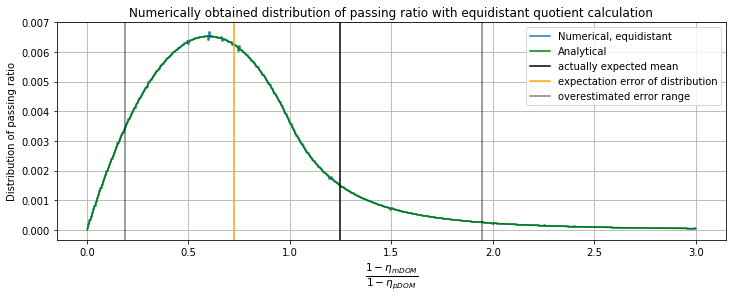

In [188]:
reso = 501

bins = np.linspace(0,3,reso)
hist, bin_edges = np.histogram(val_, bins = bins, weights=wei_)
norm = np.sum(hist)
hist = hist/norm
bin_centers = (bins[:-1] + bins[1:])/2

expect = np.dot(bin_centers, hist)

'''overwrite ratio here! watch out!'''
ratio = expect_mdom*expect_one_over_p_inv_pdom

print('Expectation value: ' + str(expect))
print('Actually expect: ' + str(ratio))

plt.title('Numerically obtained distribution of passing ratio with equidistant quotient calculation')
plt.xlabel(r'$\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$', fontsize = 15)
plt.ylabel('Distribution of passing ratio')
plt.step(bin_centers,hist, where = 'mid', label = 'Numerical, equidistant')
plt.plot(w ,p, color = 'green', label = 'Analytical')
plt.axvline(x = ratio, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', label = 'actually expected mean')
plt.axvline(x = expect, ymin = 0, ymax = 1, linewidth = 1.5, color = 'orange', label = 'expectation error of distribution')
plt.axvline(x = over_error_low, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5, label = 'overestimated error range')
plt.axvline(x = over_error_top, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5)

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('num_ratio.png')
plt.show()

Expectation value: 0.74971669865
Actually expect: 0.6666666666666664


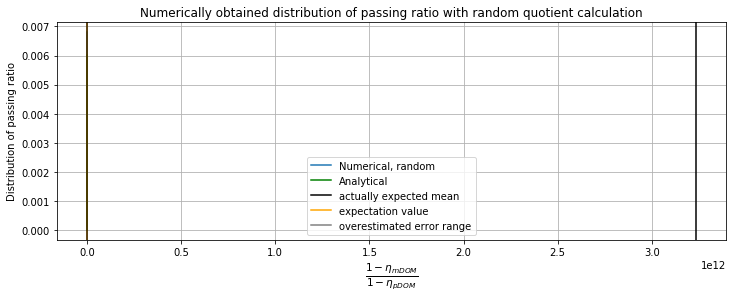

In [104]:
bins = np.linspace(0,3,reso)
hist, bin_edges = np.histogram(val, bins = bins, weights=wei)
norm = np.sum(hist)
hist = hist/norm

bin_centers = (bins[:-1] + bins[1:])/2

expect = np.dot(bin_centers, hist)

print('Expectation value: ' + str(expect))
print('Actually expect: ' + str((1-veto_efficiency_mdom)/(1-veto_efficiency_pdom)))

plt.title('Numerically obtained distribution of passing ratio with random quotient calculation')
plt.xlabel(r'$\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$', fontsize = 15)
plt.ylabel('Distribution of passing ratio')
plt.step(bin_centers,hist, where = 'mid', label = 'Numerical, random')
plt.plot(w,p, color = 'green', label = 'Analytical')
plt.axvline(x = ratio, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', label = 'actually expected mean')
plt.axvline(x = expect, ymin = 0, ymax = 1, linewidth = 1.5, color = 'orange', label = 'expectation value')
plt.axvline(x = over_error_low, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5)
plt.axvline(x = over_error_top, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5, label = 'overestimated error range')

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('num_ratio_rand.png')
plt.show()